In [1]:
import numpy as np
import pandas as pd

import arviz as az
import corner

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfd = tfp.distributions
tfb = tfp.bijectors

2022-06-10 11:29:37.755731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-10 11:29:37.755745: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import bilby

from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

In [4]:
label = 'GW150914'
time_of_event = bilby.gw.utils.get_event_time(label)

In [5]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

In [6]:
H1_data = TimeSeries.fetch_open_data("H1", time_of_event, 
                                     time_of_event + 2,
                                     sample_rate=4096, cache=True)

L1_data = TimeSeries.fetch_open_data("L1", time_of_event, 
                                     time_of_event + 2,
                                     sample_rate=4096, cache=True)

In [7]:
H1.set_strain_data_from_gwpy_timeseries(H1_data)
L1.set_strain_data_from_gwpy_timeseries(L1_data)

In [8]:
interferometers = [H1, L1]

In [9]:
prior = {}
prior['mass_ratio'] = 0.977647
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066
prior['phase'] =  5.30408
prior['geocent_time'] = 1126259462.4146729

prior['chirp_mass'] = Uniform(
    name='chirp_mass',
    latex_label='$M$',
    minimum=25.0,
    maximum=35.0,
    unit='$M_{\\odot}$')

In [10]:
prior_dict = bilby.core.prior.PriorDict(prior)

In [11]:
example = prior_dict.sample()

In [12]:
log_p = prior_dict.ln_prob(example)

In [13]:
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=100.)

waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

11:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [14]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers,
    waveform_generator,
    priors=prior)

In [15]:
w = waveform_generator.frequency_domain_strain(example)

/home/auratrik/Anaconda33/envs/igwn-py39-lw/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


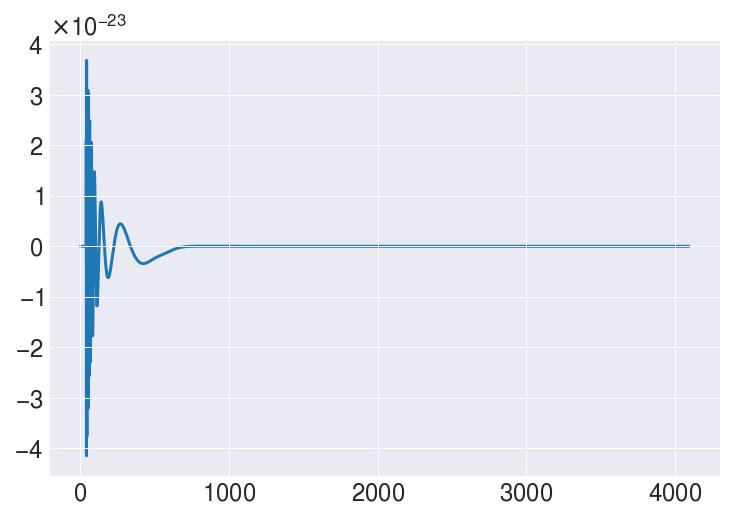

In [16]:
plt.plot(w['plus'])

In [17]:
likelihood.parameters.update(example)
log_l = likelihood.log_likelihood() 
log_post = log_p + log_l

11:29 bilby INFO    : Generating frequency domain strain from given time domain strain.
11:29 bilby INFO    : Applying a tukey window with alpha=0.2, roll off=0.2
11:29 bilby INFO    : Generating frequency domain strain from given time domain strain.
11:29 bilby INFO    : Applying a tukey window with alpha=0.2, roll off=0.2


In [18]:
print(log_post)

-153540960.86183676


2022-06-10 11:29:54.773051: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-10 11:29:54.773070: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (auratrik-Lenovo-Legion-5-15IMH05): /proc/driver/nvidia/version does not exist
2022-06-10 11:29:54.773452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


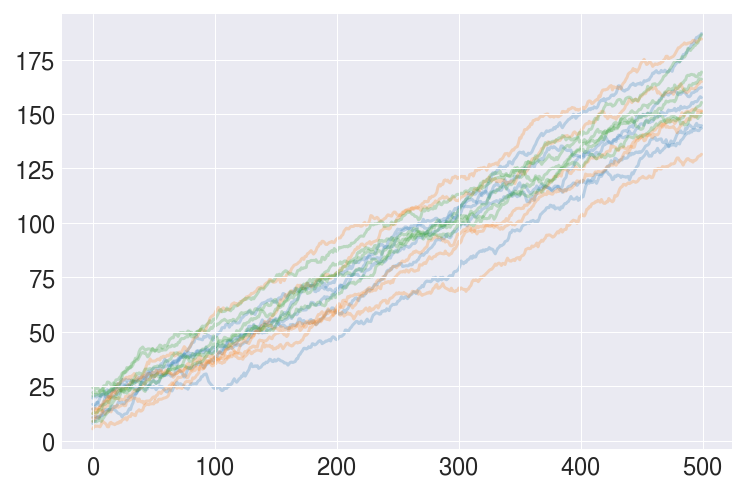

In [19]:
ndim = 3
nsample, nchain = 500, 5

def target_log_prob(log_post):
    #mean, var= tf.nn.moments(x, axes = [0, 1], keepdims = True)
    #return -tf.reduce_sum(((2*np.pi*var)**(-0.5))*np.exp((-(x - mean)**2)/(2*var)))
    return tf.convert_to_tensor(log_post)

hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob,
    num_leapfrog_steps=3,
    step_size=.25)

samples, is_accepted = tfp.mcmc.sample_chain(
    kernel=hmc_kernel,
    num_results=nsample,
    num_burnin_steps=50,
    trace_fn=lambda _, pkr: pkr.is_accepted,
    current_state=tf.zeros([nchain, ndim]))

for i in range(ndim):
  plt.plot(samples[..., i], alpha=.25, color=f'C{i}');


result_mc = bilby.run_sampler(log_l,
                              log_p,
                              sampler='dynesty',
                              outdir='short_mc_only',
                              walks=5,
                              nlive=50,
                              label=label)